In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from ModulationPy import ModulationPy
from commpy import rrcosfilter
from matplotlib import pyplot as plt

from src.optics.split_step_fourier import SplitStepFourier
from src.general_methods.visualizer import Visualizer
from myFNFTpy.FNFTpy import nsev_inverse_xi_wrapper, nsev_inverse, nsev

### 0) input message:
we choose number of bits based on the number of symbols we want

so, number of bits: $ N_b = N_s*N_{sps} = 2048 $
where $ N_{sps} = log_2(M_{QAM}) = 4 $ is the num of samples per symbol

we get:
$ b=[b_0, b_1, ..., b_{N_b}] : b_i\in{0,1} \; \forall i$

In [3]:
m_qam = 16
num_symbols = 512
sps = int(np.log2(m_qam))
length_of_msg = num_symbols*sps
x0 = np.random.choice([0, 1], size=length_of_msg)

# plot
Visualizer.print_bits(x0, sps, 'message before channel')


_______________________________________________
message before channel - len=2048
[[1 1 1 0]
 [0 1 1 1]
 [0 0 1 1]
 ...
 [0 0 1 0]
 [1 1 0 1]
 [1 1 1 1]]


### 1) Modulation
$ s = f_{MOD}(b) = [s_0, s_1, ... , s_{N_s}] : s_i = a_i + jb_i $

s.t:
$ f_{MOD}:B^{N_s*N_{sps}} \rightarrow C^{N_s}  $
$ N_s = 512 $

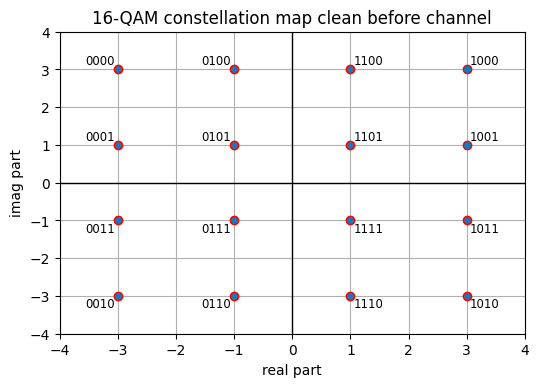

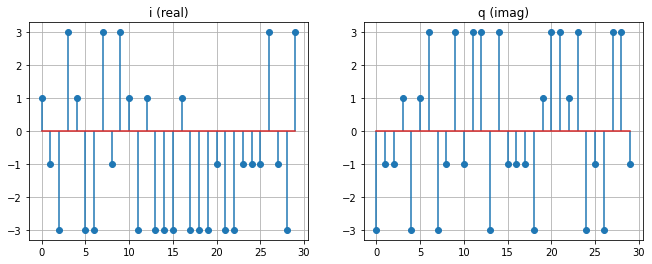

num of symbols = 512


In [4]:
modem = ModulationPy.QAMModem(m_qam, soft_decision=False)
x1 = modem.modulate(x0)

# plot
Visualizer.plot_constellation_map_with_points(x1, m_qam, 'clean before channel')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
Visualizer.my_plot(np.real(x1[0:30]), function='stem', name='i (real)', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(x1[0:30]), function='stem', name='q (imag)', ax=ax2)
print(f'num of symbols = {len(x1)}')

### 2) over sampling

$ \hat s = [s_0, [0, 0, ..., 0], s_1, [0, 0, ..., 0], ..., s_{\hat N}, [0, 0, ..., 0]] $

s.t:

$ \hat s \in R^{\hat N} : \hat N = N_s*N_{os}= 4096 $ <br>
$ N_{os} = 8 $

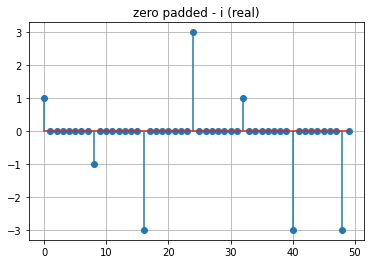

vec length = 4096, over_sampling period = 8


In [5]:
over_sampling = 8  # sampling rate

x2 = np.zeros(over_sampling*len(x1), dtype=np.complex64)
x2[::over_sampling] = x1

# plot
Visualizer.my_plot(np.real(x2[0:50]), name='zero padded - i (real)', function='stem')
print(f'vec length = {len(x2)}, over_sampling period = {over_sampling}')

### 3) Pulse shaping
$ X[\xi] = h \circledast s  $

length of h, $N_h$ is chosen such that the length of X, $N_X$ will be the next closest power of 2
* (unless its too small [less than 100], so we skip to the next closest power of 2)

for $ \hat N = 4096 $ we chose $ N_h = 4097 $
and we get $ N_X = 8192 $

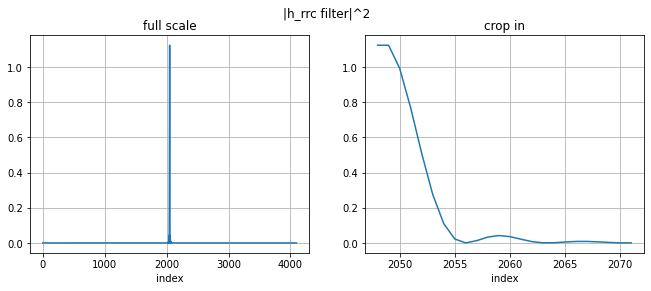

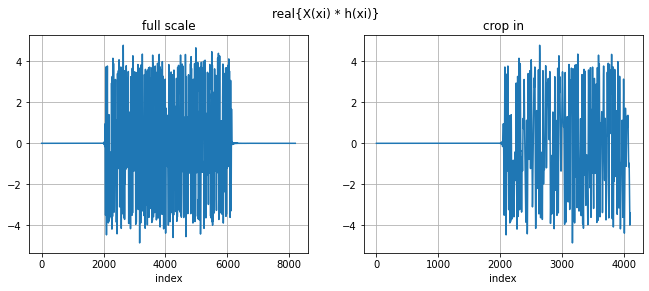

filter len = 4097, signal len = 8192


In [6]:
roll_off = 0.25  # filter roll-off factor
Ts = 3000  # symbol period

lenx = len(x2)
desired_len = int(2 ** np.ceil(np.log2(lenx)))  # the next power of 2
if desired_len - lenx < 100:
    desired_len = int(2 ** (1 + np.ceil(np.log2(lenx))))  # the next next power of 2

N_rrc = int(np.ceil(desired_len - lenx)) + 1
alpha: float = roll_off  # default = 0.25
fs = over_sampling/Ts
h_ind, h_rrc = rrcosfilter(N_rrc, alpha, Ts, fs)
x3 = np.convolve(h_rrc, x2)  # Waveform with PSF

#plot
zm = range(N_rrc//2, N_rrc//2 + 24)
Visualizer.twin_zoom_plot('|h_rrc filter|^2', np.abs(h_rrc) ** 2, zm)
Visualizer.twin_zoom_plot('real{X(xi) * h(xi)}', np.real(x3), range(0, N_rrc))

print(f'filter len = {N_rrc}, signal len = {len(x3)}')

### 4) pre-equalize
$ \hat X(\xi) = X \cdot A_\mu$

In [7]:
normalization_factor: float = 1e-3
x4 = normalization_factor*x3

# plot
print(f'signal len = {len(x4)}')

signal len = 8192


### 5) INFT

$ x(t) = \mathcal{F}^{-1}\{\hat X\} $

with the following params:
* $ N_\xi = N_{sps} \cdot N_{os} = len(\hat X) $
* $ N_t = 2 ^ {\lfloor log_2(N_\xi) \rfloor}$
* $ t = [\frac{-N_t}{2}:\frac{N_t}{2}] * dt $

xi ∈ [-1.57:1.57] Hz ,	 N_xi   (=M) = 8192
t  ∈ [-4096.00:4095.00] s  ,	 N_time (=D) = 8192
BW = 1.57 Hz


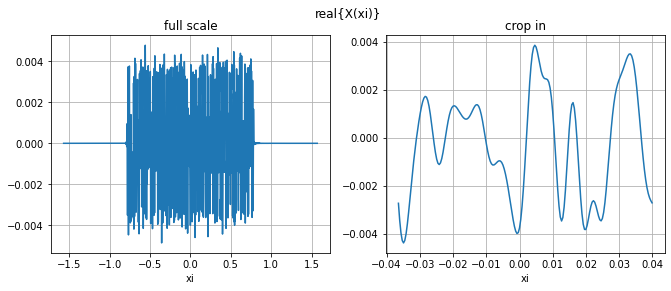

In [8]:
# generate INFT params:
dt = 1#e-12
N_xi = len(x3)
N_time = int(2 ** np.floor(np.log2(N_xi)))  # (=D)
tvec = np.arange(start=-N_time/2, stop=N_time/2)*dt  # np.linspace(-t0, t0, N_time)
rv, xi = nsev_inverse_xi_wrapper(N_time, tvec[0], tvec[-1], N_xi, display_c_msg=True)
xivec = xi[0] + np.arange(N_xi)*(xi[1] - xi[0])/(N_xi - 1)
BW = xivec.max()

#plot
print(
    f'xi ∈ [{xivec[0]/1:.2f}:{xivec[-1]/1:.2f}] Hz ,\t N_xi   (=M) = {N_xi}\n'
    f't  ∈ [{tvec[0]*1:.2f}:{tvec[-1]*1:.2f}] s  ,\t N_time (=D) = {N_time}\n'
    f'BW = {BW/1:.2f} Hz'
)
Visualizer.twin_zoom_plot('real{X(xi)}', np.real(x4), range(4000, 4200), xivec, xlabel='xi')


length of INFT(x) = 8192
signal power = 2.29e-03
signal bw = [-6.32e+02:6.34e+02]


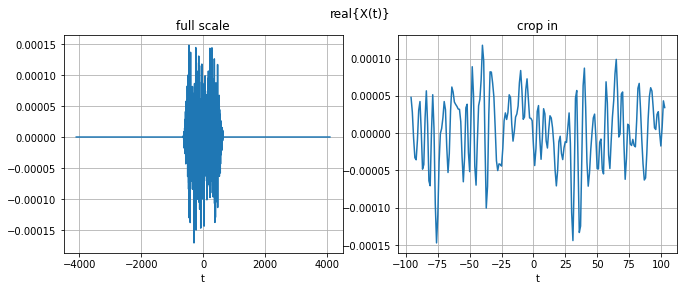

In [9]:
# INFT
contspec = x4
bound_states = []  # np.array([0.7j, 1.7j])
discspec = []  # [1.0, -1.0]

cst = 1  # continuous spectrum type - default is None
dst = 0  # default is None

res = nsev_inverse(xivec, tvec, contspec, bound_states, discspec,
                   cst=cst, dst=dst, display_c_msg=True)

assert res['return_value'] == 0, "INFT failed"
x5 = res['q']  # q[t,0]

# plot
print(f'length of INFT(x) = {len(x5)}')
Visualizer.print_signal_specs(x5, tvec)
Visualizer.twin_zoom_plot('real{X(t)}', np.real(x5), range(4000, 4200), tvec, 't')

### 6) SSF

now we go through the SSF channel
which has N iterations

#### algorithm:
* $ w = [0,...,\frac{N_t}{2},\frac{-N_t}{2},...,-1] \cdot \frac{2 \pi}{N_t*dt}  $
* $ v_1 = exp(j\Delta_z\frac{\beta_2}{2} w^2) $
* $ N = \frac{1}{\Delta_z}(1 + Z_N \cdot \frac{t_0^2}{\beta_2}) $ < old
* $ N = \frac{Z_N}{\Delta_z} $
* $ Z_0 = T_0^2/|\beta_2|$
* $ P_0 = 1/(\gamma Z_0) $
* $ a = x * \sqrt{P_0}$
* loop N times:
    * $ a = \mathcal{F}(a) \cdot v_1 $
    * $ a = \mathcal{F}^{-1}(a) $
    * $ a = a*exp(j \gamma \Delta_z |a|^2) $
* return $a/ \sqrt{P_0}$

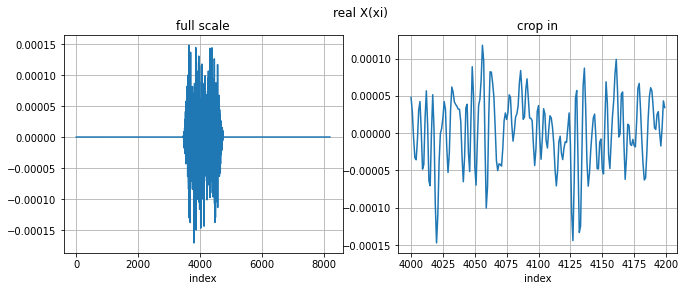

In [10]:
ssf = SplitStepFourier(
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12,
    dt=dt,
    z_n= 1000e3 ,#1.51, # units=m > TODO: set to 1000-1500km
    # TODO: change z_n to total length and N=total len / h
    h=200 # delta z > TODO: set to 200m
)

x6 = ssf(x5)

Visualizer.twin_zoom_plot('real X(xi)', np.real(x6), range(4000, 4200))

### 7) NFT
nft back to $ \xi $ domain

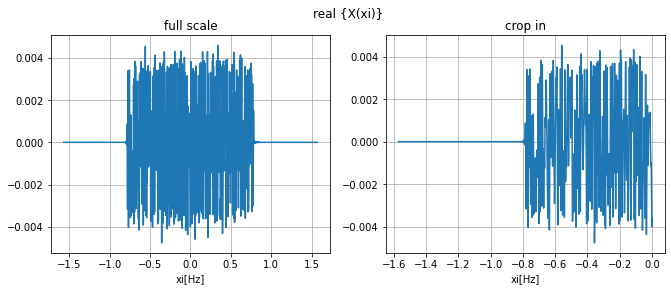

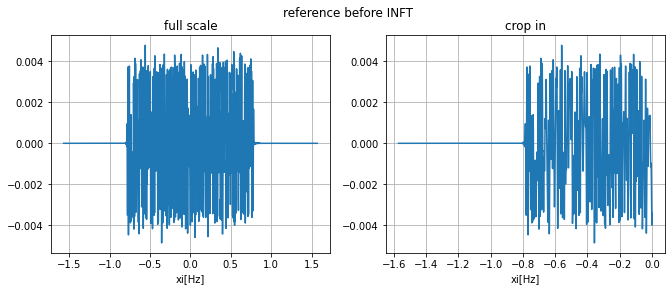

In [11]:
res = nsev(x6, tvec, Xi1=-BW, Xi2=BW, M=N_xi, display_c_msg=True)
assert res['return_value'] == 0, "NFT failed"
x7 = res['cont_ref']  # r[xi,L]

# plot
zm = range(0, N_rrc)
Visualizer.twin_zoom_plot('real {X(xi)}', np.real(x7), zm, xivec, 'xi[Hz]')
Visualizer.twin_zoom_plot('reference before INFT', np.real(x4),zm, xivec, 'xi[Hz]')


### 8) Equalizer
normalize back
$ \hat X(\xi) = X / A_\mu$

and later on the deep learning model should be placed here


In [12]:
x8 = x7 / normalization_factor

### 9) Match Filter
convolve again with the rrc filter and sample every $ N_{over sample}=8 $ points, those points are free from inter symbol interference (aliasing)

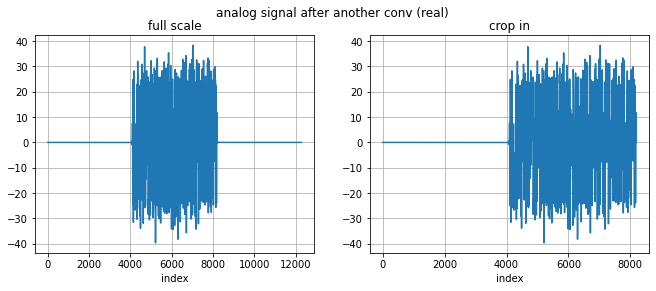

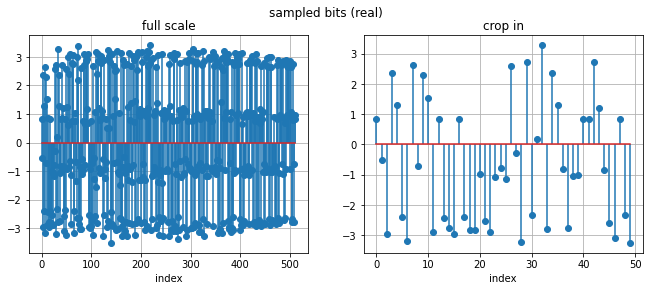

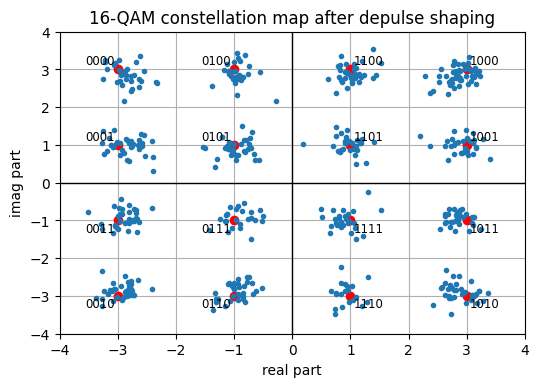

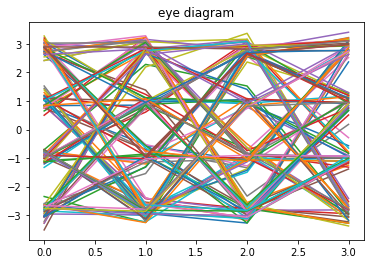

num of sampled symbols = 512 


In [14]:
y1 = np.convolve(x8, h_rrc)

# sampling the analog vector into discrete bits
start = N_rrc
stop = - N_rrc  # + over_sampling
step = over_sampling
x9 = y1[start:stop:step] / over_sampling

Visualizer.twin_zoom_plot('analog signal after another conv (real)',np.real(y1),range(0,2*N_rrc))
Visualizer.twin_zoom_plot('sampled bits (real)',np.real(x9),range(0,50),function='stem')
Visualizer.plot_constellation_map_with_points(x9, m_qam, 'after depulse shaping')
Visualizer.eye_diagram(x9, sps=sps)
print(f'num of sampled symbols = {len(x9)} ')

### 10) demodulation
restore back from i q symbols to bits

In [15]:
x10 = modem.demodulate(x9)

#plot
Visualizer.print_bits(x10, sps, 'message after channel')


_______________________________________________
message after channel - len=2048
[[1. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 ...
 [0. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]]


### Evaluate:
calculate ber

In [16]:
num_errors = (x0 != x10).sum()
ber = num_errors / length_of_msg

print(f'ber = {ber} = {num_errors}/{length_of_msg}')


ber = 0.0 = 0/2048
